In [ ]:
import zipfile
import os

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [ ]:
import os

directories = 'Dataset_BUSI_with_GT/'

unique_classes = []
for path in os.listdir(directories):
    unique_classes.append(path)

print('Unique classes:\n', unique_classes)

Unique classes:
 ['malignant', 'normal', 'benign']


In [ ]:
import cv2
from pandas import DataFrame

def bounding_box_img(filepath):
    img = cv2.imread(filepath)
    height, width, channels = img.shape

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
    return (height, width, channels, x, y, w, h)

def extract_label(filepath):
    if 'malignant' in filepath:
        return 'malignant'

dict_img = {'filename': [], 'img height': [], 'img width': [], 'img channels': [],
            'xmin': [], 'ymin': [], 'width': [], 'height': [], 'label': []}

def extract_metadata(file_dir):
    masks = sorted(os.listdir(file_dir))
    for f in masks:
        if 'mask' in f:
            full_path = os.path.join(file_dir, f)
            height, width, channels, x, y, w, h = bounding_box_img(full_path)

            if x is not None:
                dict_img['filename'].append(f)
                dict_img['img height'].append(height)
                dict_img['img width'].append(width)
                dict_img['img channels'].append(channels)
                dict_img['xmin'].append(x)
                dict_img['ymin'].append(y)
                dict_img['width'].append(w)
                dict_img['height'].append(h)
                dict_img['label'].append(extract_label(f))

extract_metadata('Dataset_BUSI_with_GT/malignant/')

df_img = DataFrame(dict_img)
df_img.head()

,filename,img height,img width,img channels,xmin,ymin,width,height,label
0,malignant (1)_mask.png,598,449,3,8,133,432,271,malignant
1,malignant (10)_mask.png,393,462,3,206,36,100,78,malignant
2,malignant (100)_mask.png,476,557,3,159,70,236,120,malignant
3,malignant (101)_mask.png,559,883,3,237,95,404,279,malignant
4,malignant (102)_mask.png,551,916,3,186,128,396,285,malignant


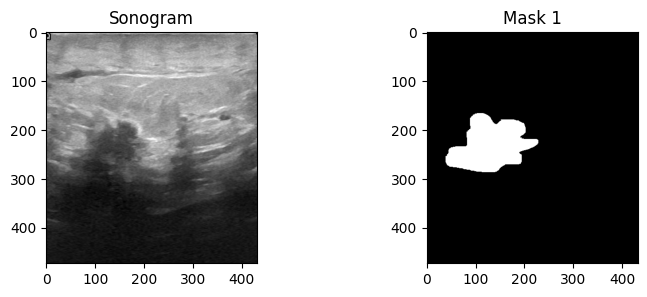

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(1, 2, figsize=(9, 3))

image = Image.open(r'Dataset_BUSI_with_GT/malignant/malignant (4).png')
axs[0].imshow(image)
axs[0].set(title='Sonogram')

image = Image.open(r'Dataset_BUSI_with_GT/malignant/malignant (4)_mask.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

plt.show()

In [ ]:
from glob import glob

def generate_single_masks(label):
    directory = f'Dataset_BUSI_with_GT/{label}/'

    mask_files = glob(os.path.join(directory, '*_mask*.png'))

    def get_base_name(filepath):
        filename = os.path.basename(filepath)
        base_name = filename.split('_mask')[0]
        return base_name

    mask_groups = {}
    for mask in mask_files:
        base_name = get_base_name(mask)
        if base_name not in mask_groups:
            mask_groups[base_name] = []
        mask_groups[base_name].append(mask)

    for base_name, files in mask_groups.items():
        overlayed_mask = None

        for file in files:
            mask = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

            if overlayed_mask is None:
                overlayed_mask = mask
            else:
                overlayed_mask = cv2.add(overlayed_mask, mask)

        output_filename = os.path.join(directory, f'{base_name}_overlayed.png')
        cv2.imwrite(output_filename, overlayed_mask)

generate_single_masks(label='malignant')

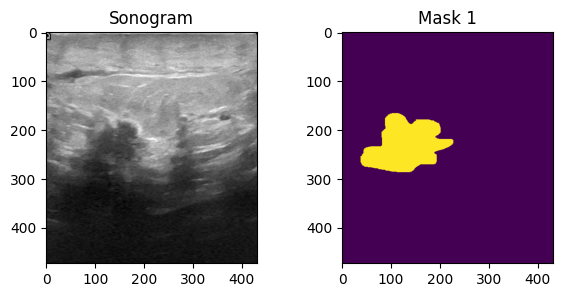

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

image = Image.open(r'Dataset_BUSI_with_GT/malignant/malignant (4).png')
axs[0].imshow(image)
axs[0].set(title='Sonogram')

image = Image.open(r'Dataset_BUSI_with_GT/malignant/malignant (4)_overlayed.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

plt.show()

In [ ]:
# directory = 'Dataset_BUSI_with_GT/malignant/'

# files_to_delete = glob(os.path.join(directory, '*overlayed*.png'))

# for file in files_to_delete:
#     try:
#         os.remove(file)
#     except OSError as e:
#         print(f'Error deleting {file}: {e}')

In [ ]:
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_images(image_paths, img_size=256, mask=False):
    if mask:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 1))
    else:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 3))

    for i, image in enumerate(image_paths):
        img = np.round(resize(img_to_array(load_img(image))/255., (img_size, img_size)), 4)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images

In [ ]:
root_path = r'Dataset_BUSI_with_GT/'
unique_classes = ['malignant']

sorted_mask_paths = sorted([sorted(glob(root_path + name + '/*overlayed.png')) for name in unique_classes])

image_paths = []
mask_paths = []
for class_path in sorted_mask_paths:
    for path in class_path:
        img_path = path.replace('_overlayed', '')
        image_paths.append(img_path)
        mask_paths.append(path)

images = load_images(image_paths, img_size=256)
masks = load_images(mask_paths, img_size=256, mask=True)

print('Number of samples:', len(images))
print('Image shape:', images[0].shape, ', Mask shape:', masks[0].shape)

Number of samples: 210
Image shape: (256, 256, 3) , Mask shape: (256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.20, random_state=42)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 168
Testing samples: 42


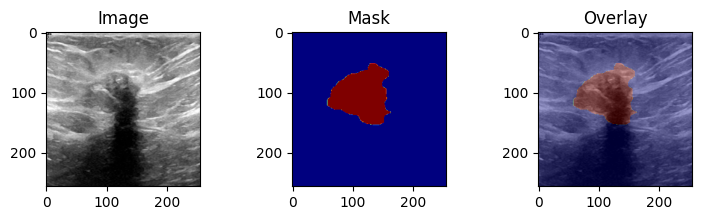

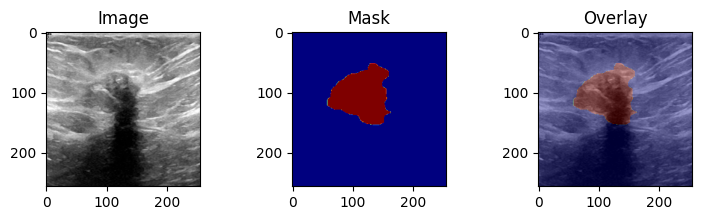

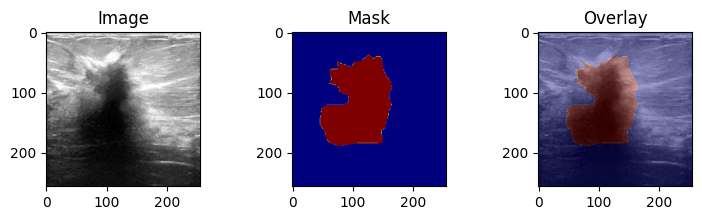

In [ ]:
def visualize_dataset(idx):
    fig, axs = plt.subplots(1, 3, figsize=(9, 2))

    axs[0].imshow(images[idx])
    axs[0].set(title='Image')

    axs[1].imshow(masks[idx], cmap='jet')
    axs[1].set(title='Mask')

    axs[2].imshow(images[idx])
    axs[2].imshow(masks[idx], cmap='jet', alpha=0.4)
    axs[2].set(title='Overlay')

    plt.show()

for i in [200, 200, 5]:
    visualize_dataset(idx=i)

In [ ]:
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Add, Multiply, BatchNormalization
from tensorflow.keras.models import Model

class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = None
        self.drop = None
        self.c2 = None
        self.pool = None if not pooling else MaxPool2D()

    def build(self, input_shape):
        self.c1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')

        super(EncoderBlock, self).build(input_shape)

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 'filters': self.filters,
            'rate': self.rate, 'pooling': self.pooling
        }

class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'rate': self.rate}

class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'bn': self.bn}

In [ ]:
def attention_unet_mod(img_height=256, img_width=256, img_channels=3):
    inputs = Input(shape=(img_height, img_width, img_channels))

    p1, c1 = EncoderBlock(32, rate=0.1, name='Encoder_1')(inputs)
    p2, c2 = EncoderBlock(64, rate=0.1, name='Encoder_2')(p1)
    p3, c3 = EncoderBlock(128, rate=0.2, name='Encoder_3')(p2)
    p4, c4 = EncoderBlock(256, rate=0.2, name='Encoder_4')(p3)

    encoding = EncoderBlock(512, 0.3, pooling=False, name='Encoding')(p4)

    a1 = AttentionGate(256, bn=True, name='Attention_1')([encoding, c4])
    d1 = DecoderBlock(256, rate=0.2, name='Decoder_1')([encoding, a1])

    a2 = AttentionGate(128, bn=True, name='Attention_2')([d1, c3])
    d2 = DecoderBlock(128, rate=0.2, name='Decoder_2')([d1, a2])

    a3 = AttentionGate(64, bn=True, name='Attention_3')([d2, c2])
    d3 = DecoderBlock(64, rate=0.1, name='Decoder_3')([d2, a3])

    a4 = AttentionGate(32, bn=True, name='Attention_4')([d3, c1])
    d4 = DecoderBlock(32, rate=0.1, name='Decoder_4')([d3, a4])

    outputs = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name='Attention_U-Net')
    return model

att_model = attention_unet_mod()
att_model.summary()

Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_1           │ [(None, 128, 128, │     10,144 │ input_layer[0][0] │
│ (EncoderBlock)      │ 32), (None, 256,  │            │                   │
│                     │ 256, 32)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_2           │ [(None, 64, 64,   │     55,424 │ Encoder_1[0][0]   │
│ (EncoderBlock)      │ 64), (None, 128,  │            │                   │
│                     │ 128, 64)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_3           │ [(None, 32, 32,   │    221,440 │ Encoder_2[0][0]   │
│ (EncoderBlock)      │ 128), (None, 64,  │            │                   │
│                     │ 64, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_4           │ [(None, 16, 16,   │    885,248 │ Encoder_3[0][0]   │
│ (EncoderBlock)      │ 256), (None, 32,  │            │                   │
│                     │ 32, 256)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoding            │ (None, 16, 16,    │  3,539,968 │ Encoder_4[0][0]   │
│ (EncoderBlock)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_1         │ (None, 32, 32,    │  1,771,265 │ Encoding[0][0],   │
│ (AttentionGate)     │ 256)              │            │ Encoder_4[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_1           │ (None, 32, 32,    │  2,359,808 │ Encoding[0][0],   │
│ (DecoderBlock)      │ 256)              │            │ Attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_2         │ (None, 64, 64,    │    443,265 │ Decoder_1[0][0],  │
│ (AttentionGate)     │ 128)              │            │ Encoder_3[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_2           │ (None, 64, 64,    │    590,080 │ Decoder_1[0][0],  │
│ (DecoderBlock)      │ 128)              │            │ Attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_3         │ (None, 128, 128,  │    111,041 │ Decoder_2[0][0],  │
│ (AttentionGate)     │ 64)               │            │ Encoder_2[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_3           │ (None, 128, 128,  │    147,584 │ Decoder_2[0][0],  │
│ (DecoderBlock)      │ 64)               │            │ Attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_4         │ (None, 256, 256,  │     27,873 │ Decoder_3[0][0],  │
│ (AttentionGate)     │ 32)               │            │ Encoder_1[0][1]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_4           │ (None, 256, 256,  │     36,928 │ Decoder_3[0][0],  │
│ (DecoderBlock)      │ 32)               │            │ Attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │         33 │ Decoder_4[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 10,200,101 (38.91 MB)

 Trainable params: 10,199,141 (38.91 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

att_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001, name='adam'),
    metrics=[MeanIoU(num_classes=2, name='IoU'), 'accuracy']
)

csv_logger = CSVLogger('att_unet_history.txt', append=True, separator=',')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

history = att_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=8,
    verbose=1,
    callbacks=[csv_logger, earlystop]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - IoU: 0.4243 - accuracy: 0.8215 - loss: 3.4696

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - IoU: 0.4243 - accuracy: 0.8224 - loss: 3.3828 - val_IoU: 0.4329 - val_accuracy: 0.8622 - val_loss: 0.5982
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - IoU: 0.4253 - accuracy: 0.8472 - loss: 0.3604 - val_IoU: 0.4329 - val_accuracy: 0.8622 - val_loss: 0.5211
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - IoU: 0.4230 - accuracy: 0.8595 - loss: 0.3176 - val_IoU: 0.4329 - val_accuracy: 0.8622 - val_loss: 0.5397
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - IoU: 0.4217 - accuracy: 0.8627 - loss: 0.3021 - val_IoU: 0.4329 - val_accuracy: 0.8716 - val_loss: 0.5377
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - IoU: 0.4289 - accuracy: 0.8869 - loss: 0.2733 - val_IoU: 0.4329 - val_accuracy: 0.8622 - val_loss: 0.4785
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - IoU: 0.4254 - accuracy: 0.8871 - loss: 0.2686 - val_IoU: 0.4329 - val_accuracy: 0.8529 - val_loss: 0.5021
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step

In [ ]:
att_model.save('attention_unet_mod.keras')

df_results = DataFrame(history.history)
df_results.round(4)

,IoU,accuracy,loss,val_IoU,val_accuracy,val_loss
0,0.4258,0.8410,1.5603,0.4329,0.8622,0.5982
1,0.4258,0.8487,0.3452,0.4329,0.8622,0.5211
2,0.4258,0.8642,0.3102,0.4329,0.8622,0.5397
3,0.4258,0.8703,0.3009,0.4329,0.8716,0.5377
4,0.4258,0.8857,0.2730,0.4329,0.8622,0.4785
5,0.4258,0.8799,0.2822,0.4329,0.8529,0.5021
6,0.4258,0.8870,0.2682,0.4329,0.8622,0.3817
7,0.4258,0.8977,0.2478,0.4329,0.8622,0.3976
8,0.4258,0.8987,0.2458,0.4329,0.8623,0.3947
9,0.4258,0.8969,0.2504,0.4329,0.8739,0.3657


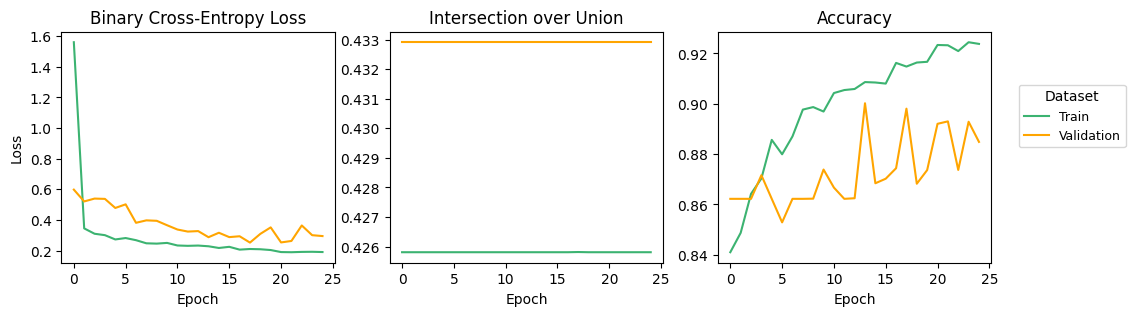

In [ ]:
# plot learning curves
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(history.history['loss'], color='mediumseagreen', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')

ax[1].plot(history.history['IoU'], color='mediumseagreen', label='Train')
ax[1].plot(history.history['val_IoU'], color='orange', label='Validation')
ax[1].set(title='Intersection over Union', xlabel='Epoch', ylabel=None)

ax[2].plot(history.history['accuracy'], color='mediumseagreen', label='Train')
ax[2].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
ax[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


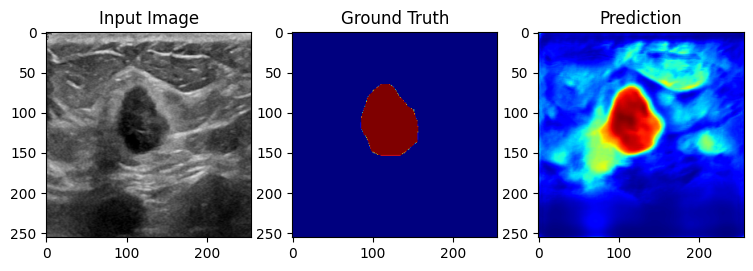

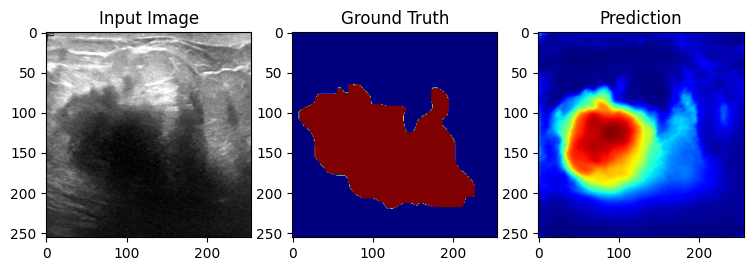

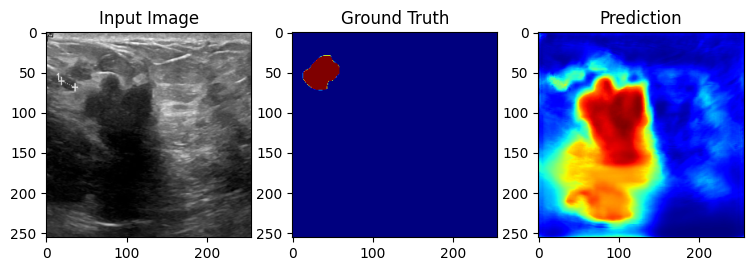

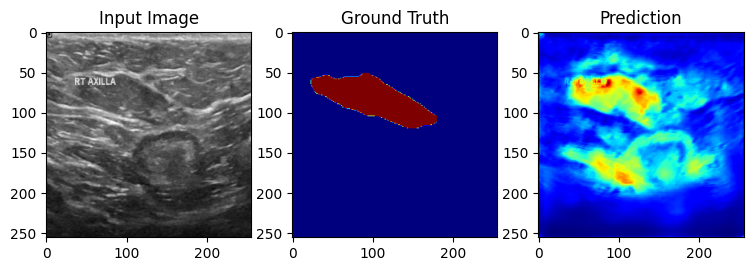

In [ ]:
from random import randint

def generate_plot():
    rand_number = randint(0, 150)
    image = images[rand_number]
    mask = masks[rand_number]

    prediction = att_model.predict(image[np.newaxis, ...], verbose=0)

    fig, axs = plt.subplots(1, 3, figsize=(9, 4))

    axs[0].imshow(image)
    axs[0].set(title='Input Image')

    axs[1].imshow(mask, cmap='jet')
    axs[1].set(title='Ground Truth')

    axs[2].imshow(np.squeeze(prediction), cmap='jet')
    axs[2].set(title='Prediction')

    plt.show()

for _ in range(0, 4):
    generate_plot()